<a href="https://colab.research.google.com/github/jiansim03/AIFFEL_ONLINE_QUEST/blob/main/Exploration06/ControlNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ControlNet으로 조건을 준 이미지 생성하기
---
- ControlNet은 Diffusion 모델에 추가 조건을 추가하여 출력되는 이미지를 쉽게 제어할 수 있습니다.
- 뿐만 아니라 ControlNet은 훈련 데이터가 작아도 학습이 잘 되고 빠르다

In [1]:
# Stable Diffusion 설치
!pip install --upgrade -qq git+https://github.com/huggingface/diffusers.git transformers accelerate

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [2]:
# 메모리 삭제 (CUDA out of memery 나올 때 사용)
# torch.cuda.empty_cache()

## 윤곽선 검출
---
- Canny 알고리즘을 사용하여 윤곽선 검출

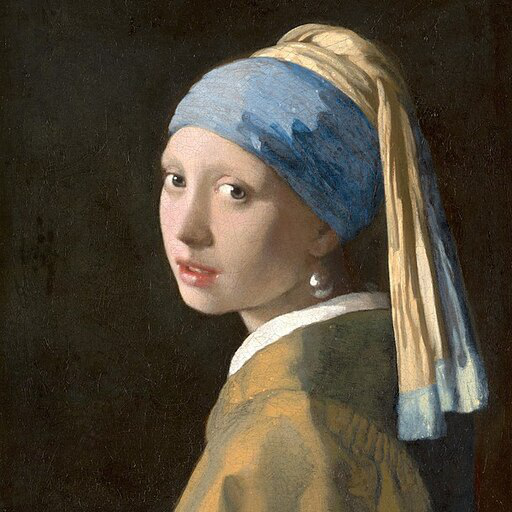

In [12]:
import torch
from diffusers import StableDiffusionControlNetPipeline
from diffusers.utils import load_image

# 이미지 불러오기
image = load_image(
    "https://hf.co/datasets/huggingface/documentation-images/resolve/main/diffusers/input_image_vermeer.png"
)

image

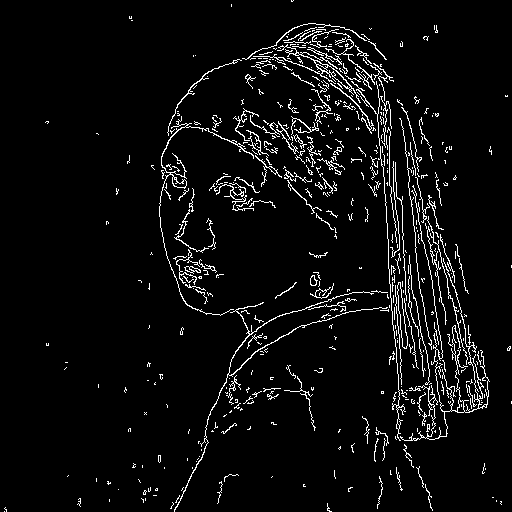

In [13]:
# OpenCV를 사용하여 이미지의 윤곽선을 검출합니다.

import cv2
from PIL import Image
import numpy as np

# 이미지를 NumPy 배열로 변환합니다.
image = np.array(image)

# threshold를 지정합니다.
low_threshold = 100
high_threshold = 200

# 윤곽선을 검출합니다.
image = cv2.Canny(image, low_threshold, high_threshold)
image = image[:, :, None] # Canny 함수의 결과는 그레이스케일 이미지이므로, 채널 차원을 추가합니다.
image = np.concatenate([image, image, image], axis=2) # 채널 차원을 3개로 복제하여 RGB 이미지로 변환합니다.
canny_image_orig = Image.fromarray(image)  # NumPy 배열을 PIL 이미지로 변환합니다.

canny_image_orig

In [5]:
# 윤곽선 검출 전처리기를 사용한 모델 파이프라인을 불러오겠습니다.

from diffusers import StableDiffusionControlNetPipeline, ControlNetModel

canny_controlnet = ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-canny", torch_dtype=torch.float16)
canny_pipe = StableDiffusionControlNetPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5", controlnet=canny_controlnet, torch_dtype=torch.float16
)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


In [6]:
torch.cuda.empty_cache()

  0%|          | 0/20 [00:00<?, ?it/s]

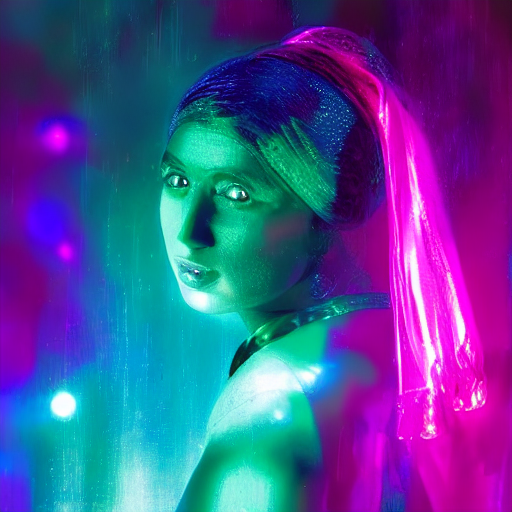

In [14]:
# 윤곽선을 추출한 이미지에 프롬프트를 적용하여 새로운 이미지를 생성

from diffusers import UniPCMultistepScheduler
canny_pipe.scheduler = UniPCMultistepScheduler.from_config(canny_pipe.scheduler.config)
canny_pipe = canny_pipe.to("cuda")

# 동일한 이미지를 생성하기 위해 seed를 지정합니다.
generator = torch.manual_seed(0)

# 이미지를 생성합니다.
canny_image_1 = canny_pipe(
    prompt="disco dancer with colorful lights",
    num_inference_steps=20,
    generator=generator,
    image=canny_image_orig
).images[0]

# 생성된 이미지를 저장합니다.
canny_image_1.save("canny_image_1.png")

# 생성된 이미지를 출력합니다.
canny_image_1

**프롬프트 외에도 부정적인 프롬프트(negative_propmt)를 넣을 수도 있고, 하이퍼파라미터를 조절할 수도 있습니다.**
- negative_propmt: 원하지 않는 요소를 적을 수 있습니다.
- controlnet_conditioning_scale: ContorlNet으로 조건을 어느 정도 주느냐를 조절합니다. Default는 1이고, 실수값으로 설정할 수 있습니다.
- num_inference_steps: 추론 횟수로, 값이 커질수록 고해상도 이미지가 출력되지만 출력되는 시간이 오래 걸립니다. default 값은 50입니다.
- guidance_scale: 얼마나 주어진 프롬프트에 근접한 이미지를 생성할지를 설정하는 하이퍼파라미터로, 값이 커질수록 문자열에 근접한 이미지가 생성되지만 이미지 품질이 떨어질 수 있습니다. default는 7.5입니다.

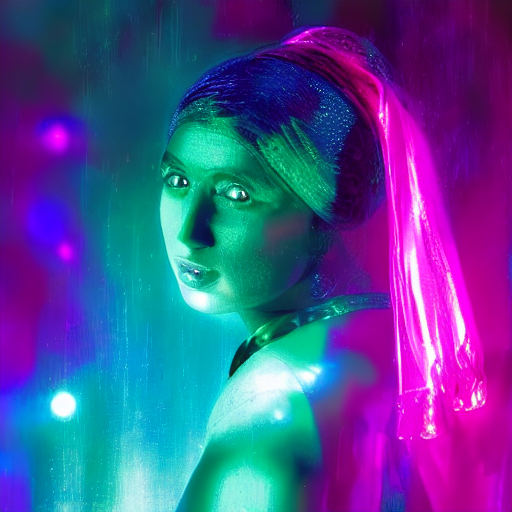

In [11]:
canny_image

  0%|          | 0/20 [00:00<?, ?it/s]

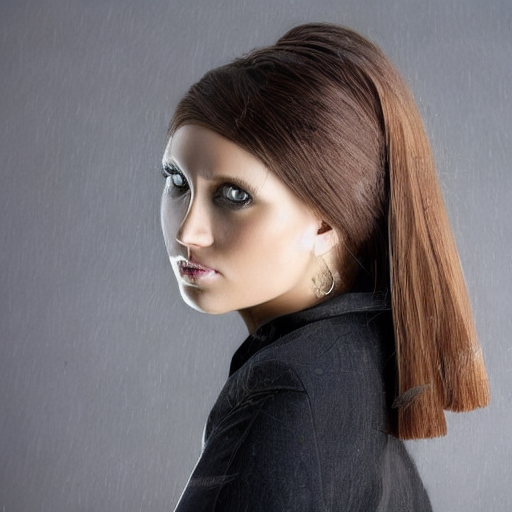

In [19]:
# 이미지를 생성합니다.
canny_image_2 = canny_pipe(
    prompt="pretty woman with long hair",
    num_inference_steps=20,
    generator=generator,
    image=canny_image_orig,
    negative_prompt="Occidental"

).images[0]

# 생성된 이미지를 저장합니다.
canny_image_2.save("canny_image_2.png")

# 생성된 이미지를 출력합니다.
canny_image_2

## 인체 자세 감지
Openpose는 인체 자세 감지(Human pose)를 할 수 있는 전처리기입니다. 자세를 감지하여 새로운 이미지를 생성해 줍니다.
먼저 사람의 전신이 담긴 이미지를 불러오겠습니다.

In [20]:
# controlnet-aux를 설치합니다. Human pose를 검출해주는 controlnet의 보조용 모델입니다.
!pip install controlnet-aux==0.0.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 2.9 MB/s eta 0:00:00


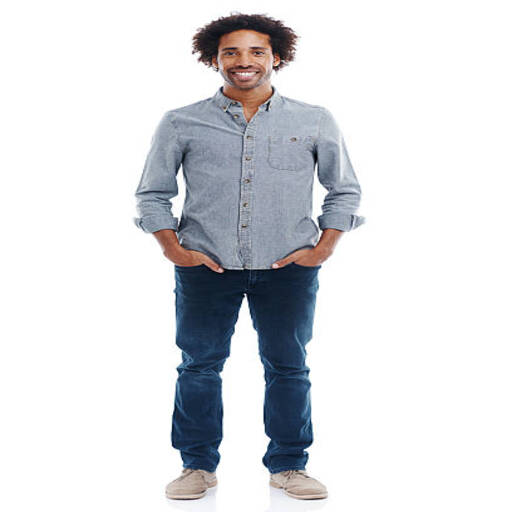

In [21]:
from diffusers.utils import load_image

openpose_image = load_image(
    "https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/diffusers/person.png"
)
openpose_image

cuda


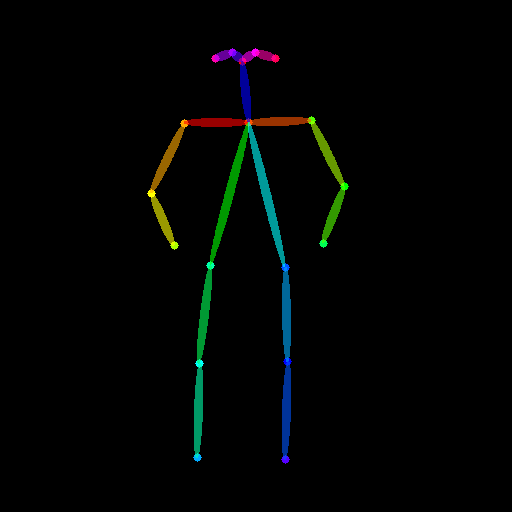

In [22]:
# Openpose 검출기를 사용하면 자세만 추출할 수 있습니다.


from controlnet_aux import OpenposeDetector

# 인체의 자세를 검출하는 사전 학습된 ControlNet 불러오기
openpose = OpenposeDetector.from_pretrained("lllyasviel/ControlNet")

# 이미지에서 자세 검출
openpose_image = openpose(openpose_image)
openpose_image

In [23]:
# Openpose 전처리기를 사용한 모델 파이프라인을 불러옵니다.

from diffusers import StableDiffusionControlNetPipeline, ControlNetModel

openpose_controlnet = ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-openpose", torch_dtype=torch.float16)
openpose_pipe = StableDiffusionControlNetPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5", controlnet=openpose_controlnet, torch_dtype=torch.float16
)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


  0%|          | 0/20 [00:00<?, ?it/s]

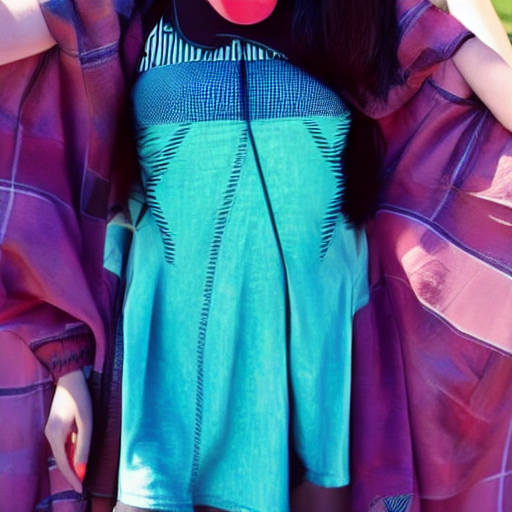

In [35]:
from diffusers import UniPCMultistepScheduler

openpose_pipe.scheduler = UniPCMultistepScheduler.from_config(openpose_pipe.scheduler.config)
openpose_pipe = openpose_pipe.to("cuda")

# Q. 코드를 작성해 보세요.
# 동일한 이미지를 생성하기 위해 seed를 넣어줍니다.
generator = torch.manual_seed(0)

#프롬프트를 작성합니다.
prompt =  "a beautiful woman wearing a dress, basking in the bright sunlight"
negative_prompt =  "wedding dress"

images = openpose_image

# 이미지를 생성합니다.
# openpose_image1 = openpose_pipe(prompt, negative_prompt, num_inference_steps=20, generator=generator, openpose_image)

openpose_image_1 = canny_pipe(
    prompt=prompt,
    negative_prompt=negative_prompt,
    num_inference_steps=20,
    generator=generator,
    image=openpose_image
).images[0]

# 생성된 이미지를 출력합니다.
openpose_image_1

  0%|          | 0/20 [00:00<?, ?it/s]

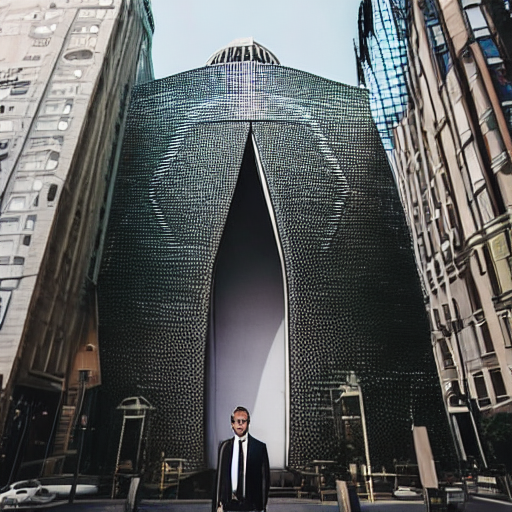

In [36]:
# Q. 프롬프트를 작성하고 하이퍼파라미터를 조절하여 이미지를 생성해 보세요.

#프롬프트를 작성합니다.
prompt =  "a man wearing a suit in city"
negative_prompt =  "passerby"

images = openpose_image

# 이미지를 생성합니다.
# openpose_image1 = openpose_pipe(prompt, negative_prompt, num_inference_steps=20, generator=generator, openpose_image)

openpose_image_2 = canny_pipe(
    prompt=prompt,
    negative_prompt=negative_prompt,
    num_inference_steps=20,
    generator=generator,
    image=openpose_image
).images[0]

# 생성된 이미지를 출력합니다.
openpose_image_2

## 윤곽선 검출 + 인체 자세 감지
---
이번에는 위에서 실습한 2가지의 전처리기를 동시에 사용해 보겠습니다. 2개의 전처리기를 controlnets라는 리스트로 만들어 파이프라인으로 전달하면 됩니다.



### Canny 알고리즘을 사용한 윤곽선 검출
---
먼저 Canny 알고리즘으로 윤곽선을 검출합니다. Canny 알고리즘으로 윤곽선을 검출한 이미지 위에 인체 자세 검출 전처리기를 올려줄 것이기 때문에 인체 자세를 넣어줄 부분을 이미지 내에서 지워주어야 한다는 점을 주의하세요.

직접 아래의 코드를 작성해 보세요.

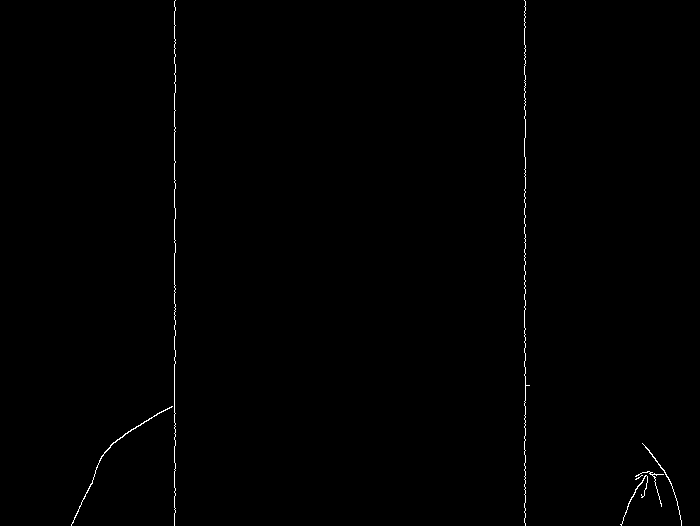

In [38]:
from diffusers.utils import load_image
from PIL import Image
import cv2
import numpy as np
from diffusers.utils import load_image

# Q. 코드를 작성해 보세요.
# 이미지를 불러오세요.
image_orig_2 = load_image("http://img.etoday.co.kr/pto_db/2017/11/20171114092528_1150866_700_526.PNG")



#threshhold를 지정합니다.
low_threshold = 100
high_threshold = 200

# 이미지를 NumPy 배열로 변환합니다.
canny_image = np.array(image_orig_2)

# 인체 감지 포즈를 넣어줄 가운데 부분을 지워줍니다.
zero_start = canny_image.shape[1] // 4
zero_end = zero_start + canny_image.shape[1] // 2
canny_image[:, zero_start:zero_end] = 0

# 윤곽선을 검출하고 NumPy 배열을 PIL 이미지로 변환합니다.
canny_image = cv2.Canny(canny_image, low_threshold, high_threshold)
canny_image = canny_image[:, :, None] # Canny 함수의 결과는 그레이스케일 이미지이므로, 채널 차원을 추가합니다.
canny_image = np.concatenate([canny_image, canny_image, canny_image], axis=2) # 채널 차원을 3개로 복제하여 RGB 이미지로 변환합니다.
canny_image = Image.fromarray(canny_image)  # NumPy 배열을 PIL 이미지로 변환합니다.

canny_image

### Openpose를 사용한 인체 자세 검출
---
인체 자세를 검출해 줍니다.

cuda


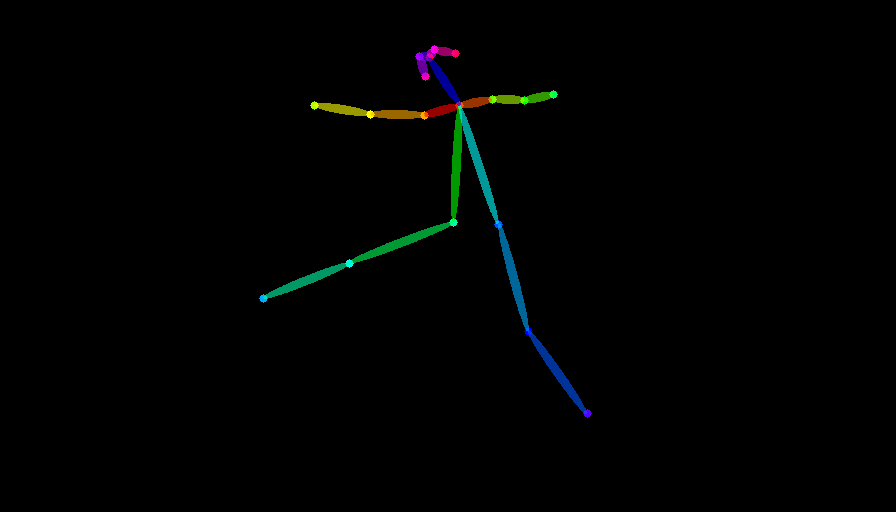

In [43]:
from controlnet_aux import OpenposeDetector
from diffusers.utils import load_image

# Q. 아래의 코드를 작성해 주세요.
# 이미지를 불러옵니다.
openpose_image_2 = load_image("https://static01.nyt.com/images/2023/05/24/arts/NYCB-season-promo/NYCB-season-highlights-07-videoSixteenByNine3000.jpg")

openpose = OpenposeDetector.from_pretrained("lllyasviel/ControlNet")

# OpenposeDetector를 사용하여 인체 자세를 검출합니다.
openpose_image_2 = openpose(openpose_image_2)
openpose_image_2

Edge Detection과 Openpose, 2개의 전처리기를 controlnets라는 리스트로 만들어 파이프라인으로 전달합니다.

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


  0%|          | 0/20 [00:00<?, ?it/s]

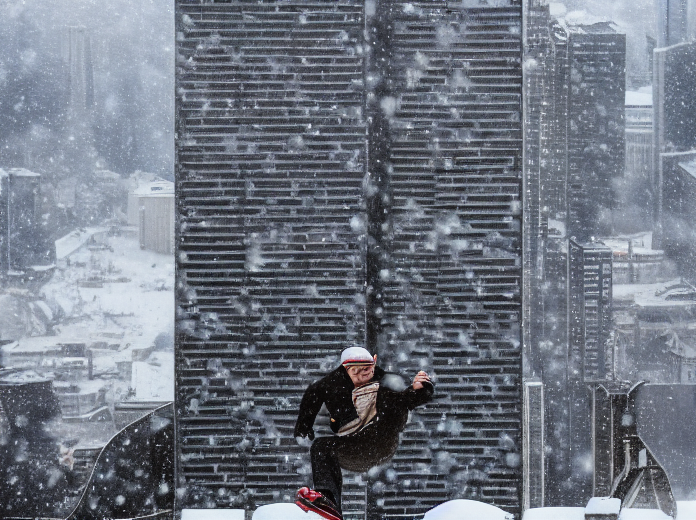

In [46]:
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel, UniPCMultistepScheduler

# Q. 코드를 작성해 보세요.
# Edge Detection과 Openpose, 2개의 전처리기를 controlnets라는 리스트로 만듭니다.

controlnets = [canny_controlnet, openpose]

# 리스트 controlnets를 파이프라인으로 전달합니다.
pipe = StableDiffusionControlNetPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5", controlnet=controlnets[0], torch_dtype=torch.float16
)

pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)
pipe = pipe.to("cuda")

# 프롬프트를 작성합니다.
prompt =  'a man jumping between buildings in winter'
negative_prompt =  'too bright light'

# seed를 지정합니다.
generator = torch.manual_seed(0)

images = [openpose_image_2, canny_image]

# 이미지를 생성합니다.
image = canny_pipe(
    prompt=prompt,
    negative_prompt=negative_prompt,
    num_inference_steps=20,
    generator=generator,
    image=canny_image
).images[0]

# 생성된 이미지를 저장합니다.
image.save("multi_controlnet_output.png")

# 생성된 이미지를 출력합니다.
image